In [1]:
import sys
print('iPython Kernel -->', sys.argv)
print('Environment -->', sys.prefix)

iPython Kernel --> ['C:\\anaconda3\\envs\\ling\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Babak Ravandi\\AppData\\Roaming\\jupyter\\runtime\\kernel-289ee242-fa8a-4296-850a-0964dcc8b9ee.json']
Environment --> C:\anaconda3\envs\ling


In [2]:
import pandas as pd
import numpy as np
import json
from collections import OrderedDict 

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import random

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns

import networkx as nx
import GraphHierarchy as gh

from tqdm import tqdm

from scipy import stats

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', 0)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%matplotlib inline

In [3]:
import os
from pandas import ExcelWriter


def save_xls(dfs_dict, xls_path, open=False):
    if type(dfs_dict) is not dict:
        dfs_dict = {'sheet1': dfs_dict}
    
    with ExcelWriter(xls_path) as writer:
        for df_name, df in dfs_dict.items():
            df.to_excel(writer, df_name)
        writer.save()

    if open is True:
        os.system('start EXCEL.EXE "{}"'.format(os.path.abspath(xls_path)))
    pass

# Load Networks

## Check Mistake Duplicate Edges & Add Frequency

THe only exception of having multiple interactions between a source and target is in 17th century as below. ALl other centuries must have only a single interaction (type of edge) between two nodes.

Source:'PR ze'	 |	Target: 'IV werden'   |   Interactions: {PP, VP}

In [4]:
path_dataset_dir = "D:/GoogleDrive/Research/Linguistic project/German/data/"

In [67]:
save_freq_files = True

path_networks_NO_FREQ = OrderedDict()

path_networks_NO_FREQ['11'] = "/01 Mittelhochdeutsch middle high/11_cent.xlsx" 
path_networks_NO_FREQ['12'] = "/01 Mittelhochdeutsch middle high/12_cent.xlsx"
path_networks_NO_FREQ['13'] = "/01 Mittelhochdeutsch middle high/13_cent.xlsx"
path_networks_NO_FREQ['E14'] = "/01 Mittelhochdeutsch middle high/14E_cent.xlsx" # Early

path_networks_NO_FREQ['L14'] = '/02 Fruhneuhochdeutsch early new high/14L_cent.xlsx' # Late
path_networks_NO_FREQ['15'] = '/02 Fruhneuhochdeutsch early new high/15_cent.xlsx'
path_networks_NO_FREQ['16'] = '/02 Fruhneuhochdeutsch early new high/16_cent.xlsx'
path_networks_NO_FREQ['17'] = '/02 Fruhneuhochdeutsch early new high/17_cent.xlsx'

cent_interaction_validate = {}
cent_raw_df = {}

for cent, path_net in path_networks_NO_FREQ.items():

#     path_net = path_networks['15']
    print('------------ Cent:', cent, ' Path:', path_net)

    cent_df = pd.read_excel( path_dataset_dir + path_net)
    
    cent_df = cent_df.drop(columns=[c for c in cent_df.columns if 'Unnamed' in c])
    

    cent_df.loc[:, ['Source', 'Target', 'Interaction']] = (
        cent_df.loc[:, ['Source', 'Target', 'Interaction']].apply(lambda x: x.str.strip(), axis=1)
    ) 

    cent_raw_df[cent] = cent_df.copy()
    
    """"""
    G=nx.from_pandas_edgelist(
        cent_df, source='Source', target='Target', 
        edge_attr=True, create_using=nx.DiGraph()
    )
    
    # nx.draw(G, with_labels=True)
    # print(type(G))
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    print('num edges in excel:', len(cent_df), ' num network edges:', G.number_of_edges())
    """"""

    cent_df['frequency'] = cent_df['Interaction']

    cent_df = (
        cent_df.groupby(['Source', 'Target'])
        .agg({
            'Interaction': lambda x: set([v.upper() for v in x]),
            'frequency': np.size,
         })
        .reset_index()
    )

    cent_df['Interaction count'] = cent_df['Interaction'].apply(len)

    # print(path_net)
    cent_df = cent_df.sort_values(by=['Interaction count', 'frequency'], ascending=False)

    if save_freq_files:
        path_export = (path_dataset_dir + path_net)[:-5] + '_freq.xlsx'
        print('   EXPORTED -->', path_export)
        cent_df.to_excel(path_export)
    
    cent_interaction_validate[cent] = cent_df[cent_df['Interaction count'] > 1]
    
    print(
        'Interaction count > 1 -->', len(cent_interaction_validate[cent])
    )
    
    del cent_df

------------ Cent: 11  Path: /01 Mittelhochdeutsch middle high/11_cent.xlsx
num edges in excel: 971  num network edges: 732
   EXPORTED --> D:/GoogleDrive/Research/Linguistic project/German/data//01 Mittelhochdeutsch middle high/11_cent_freq.xlsx
Interaction count > 1 --> 0
------------ Cent: 12  Path: /01 Mittelhochdeutsch middle high/12_cent.xlsx
num edges in excel: 1195  num network edges: 822
   EXPORTED --> D:/GoogleDrive/Research/Linguistic project/German/data//01 Mittelhochdeutsch middle high/12_cent_freq.xlsx
Interaction count > 1 --> 0
------------ Cent: 13  Path: /01 Mittelhochdeutsch middle high/13_cent.xlsx
num edges in excel: 2501  num network edges: 1362
   EXPORTED --> D:/GoogleDrive/Research/Linguistic project/German/data//01 Mittelhochdeutsch middle high/13_cent_freq.xlsx
Interaction count > 1 --> 1
------------ Cent: E14  Path: /01 Mittelhochdeutsch middle high/14E_cent.xlsx
num edges in excel: 2345  num network edges: 1345
   EXPORTED --> D:/GoogleDrive/Research/Ling

In [68]:
print('WE MUST HAVE Only two nodes with multiple edges!')
cent_interaction_validate['17']

WE MUST HAVE Only two nodes with multiple edges!


,Source,Target,Interaction,frequency,Interaction count
379,AX werden,PP er,"{PP, VP}",92,2


## Validate Trees

In [69]:
# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [70]:
def lenght_all_pairs_shortest_path(G_nx):
    q = nx.all_pairs_shortest_path(G_nx)
    
    p_all = []

    for p in q:
        p_all.append(p)

    p_lenght = []
    path_df = []
    
    for p_2 in [p[1].values() for p in p_all]:
        for p3 in p_2:
            p_lenght.append(len(p3))
            
            path_df.append({'l': len(p3), 'p': p3})
#         p_lenght += [len(p3) for p3 in p_2]

        pass
    
    path_df = pd.DataFrame(path_df)
    path_df['p'] = path_df['p'].astype('str')
    
    return path_df

In [73]:
sentence_started = False
G = None
row_num = 0
root_row_num_current = None

tree_root = None

G_list = []
G_not_tree_list = []
cent = '13'

for source, target, is_root in cent_raw_df[cent][['Source', 'Target', 'Root']].to_numpy():
    if (sentence_started is True and is_root in [1, -1]) or (row_num == len(cent_raw_df[cent]) - 1):
        sentence_started = False
        
        if(nx.is_tree(G)):
            pos = hierarchy_pos(G, root=tree_root)
            
            path_df = lenght_all_pairs_shortest_path(G)
            
            G_list.append({
                'root':tree_root, 
                'G': G,
                'diamter directed': path_df['l'].max(),
                'diameter indirected': nx.diameter(G.to_undirected()),
                'height': len(set([v[1] for v in pos.values()]))
            })
        else:
            G_not_tree_list.append((root_row_num_current, G))
#             print('not tree')
            pass
        pass
    
    if is_root == 1:
        sentence_started = True
        root_row_num_current = row_num
        tree_root = source
        G = nx.DiGraph()
        pass
    
    G.add_edge(source, target)
    
    row_num += 1
    pass

print('Num Trees:', len(G_list), 'Num NOT trees:', len(G_not_tree_list))

df = pd.DataFrame(G_list)
df.describe()

Num Trees: 664 Num NOT trees: 23


,diamter directed,diameter indirected,height
count,664.000000,664.000000,664.000000
mean,3.209337,3.233434,3.209337
std,1.122848,1.282683,1.122848
min,2.000000,1.000000,2.000000
25%,2.000000,2.000000,2.000000
50%,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000
max,6.000000,7.000000,6.000000


Cent: 13


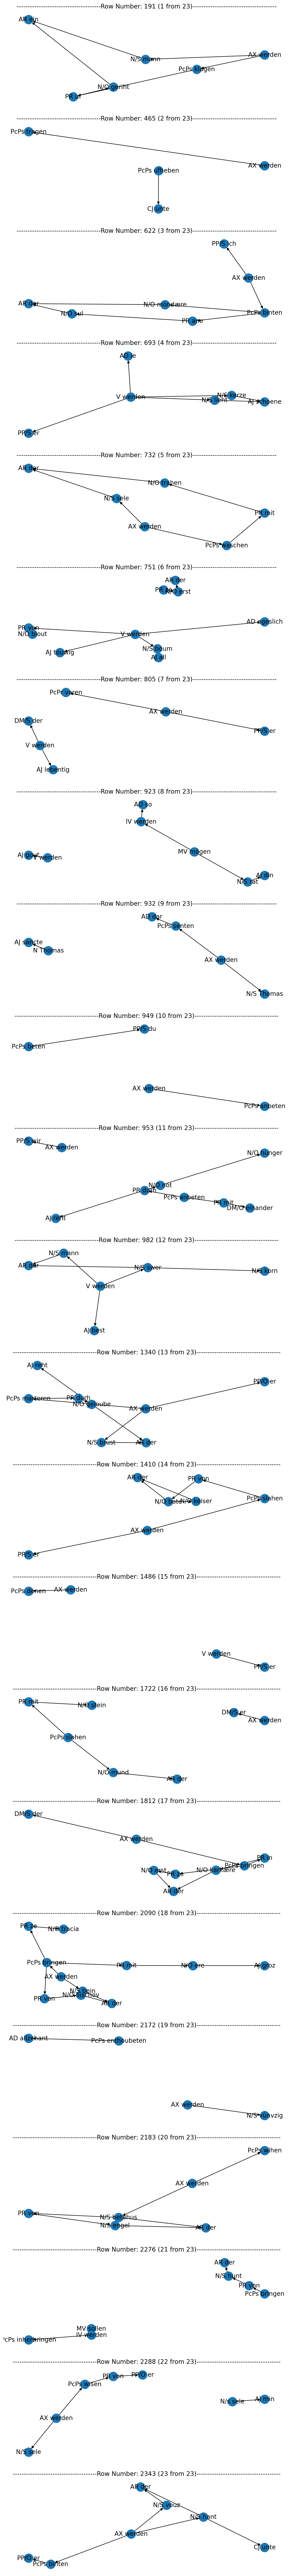

In [76]:
'''
Export Not trees
'''
not_tree_df = []
num_not_tree = len(G_not_tree_list)

fig, axs = plt.subplots(num_not_tree, figsize=(10,num_not_tree * 4), dpi=200)

for i, not_tree in enumerate(G_not_tree_list):
    not_tree_df.append({'row_num': row_num + 2, 'cent': cent})
    
    row_num, G = not_tree   

    nx.draw(G, pos=nx.spring_layout(G), with_labels = True, ax=axs[i])
    axs[i].set_title('--------------------------------------Row Number: {} ({} from {})--------------------------------------'.format(
        row_num + 2,
        i + 1,
        num_not_tree
    ))

#     print('row_num:', row_num + 2)
    pass

not_tree_df = pd.DataFrame(not_tree_df)
not_tree_df.to_excel(path_dataset_dir + 'not_tree/cent_{}.xlsx'.format(cent))

plt.savefig(path_dataset_dir + 'not_tree/cent_{}.png'.format(cent), bbox_inches='tight')

print('Cent:', cent)
# plt.tight_layout()

Cent: 13
Tree height: 4


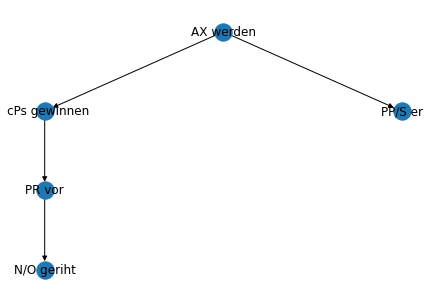

In [75]:
'''
Visualize a Tree
'''
# https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx
# from networkx.drawing.nx_pydot import graphviz_layout
# pos = graphviz_layout(giant, prog="circo")

# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
index_tree = [0, 515, 400][0]

tree_root = G_list[index_tree]['root']
G = G_list[index_tree]['G']

pos = hierarchy_pos(G, root=tree_root)

nx.draw(G, pos=pos, with_labels = True)

# nx.draw(giant, pos=nx.spring_layout(giant), with_labels = True)
print('Cent:', cent)
print('Tree height:', len(set([v[1] for v in pos.values()])))

## Load Corrected Nets with Freq

In [96]:
path_networks = OrderedDict()

path_networks['11'] = "/01 Mittelhochdeutsch middle high/11_cent_freq.xlsx" 
path_networks['12'] = "/01 Mittelhochdeutsch middle high/12_cent_freq.xlsx"
path_networks['13'] = "/01 Mittelhochdeutsch middle high/13_cent_freq.xlsx"
path_networks['E14'] = "/01 Mittelhochdeutsch middle high/14E_cent_freq.xlsx" # Early

path_networks['L14'] = '/02 Fruhneuhochdeutsch early new high/14L_cent_freq.xlsx' # Late
path_networks['15'] = '/02 Fruhneuhochdeutsch early new high/15_cent_freq.xlsx'
path_networks['16'] = '/02 Fruhneuhochdeutsch early new high/16_cent_freq.xlsx'
path_networks['17'] = '/02 Fruhneuhochdeutsch early new high/17_cent_freq.xlsx'

path_networks

OrderedDict([('11', '/01 Mittelhochdeutsch middle high/11_cent_freq.xlsx'),
             ('12', '/01 Mittelhochdeutsch middle high/12_cent_freq.xlsx'),
             ('13', '/01 Mittelhochdeutsch middle high/13_cent_freq.xlsx'),
             ('E14', '/01 Mittelhochdeutsch middle high/14E_cent_freq.xlsx'),
             ('L14',
              '/02 Fruhneuhochdeutsch early new high/14L_cent_freq.xlsx'),
             ('15', '/02 Fruhneuhochdeutsch early new high/15_cent_freq.xlsx'),
             ('16', '/02 Fruhneuhochdeutsch early new high/16_cent_freq.xlsx'),
             ('17',
              '/02 Fruhneuhochdeutsch early new high/17_cent_freq.xlsx')])

In [97]:
path_networks.keys()

odict_keys(['11', '12', '13', 'E14', 'L14', '15', '16', '17'])

In [98]:
cent_nets = OrderedDict()
syntactic_nets = []

for cent, path_net in path_networks.items():
    print('------- cent:', cent)
    
    cent_df = pd.read_excel( path_dataset_dir + path_net).drop(columns='Unnamed: 0')
    
    cent_df['Source'] = cent_df['Source'].str.lower().apply(lambda x: x.split(' ')[0].upper() + ' ' + ' '.join(x.split(' ')[1:]))
    cent_df['Target'] = cent_df['Target'].str.lower().apply(lambda x: x.split(' ')[0].upper() + ' ' + ' '.join(x.split(' ')[1:]))
    
    cent_df.loc[:, 'Source':'Target'] = cent_df.loc[:, 'Source':'Target'].apply(
        lambda x: x.str.strip())
    
#     print(cent_df.columns)
    G = nx.from_pandas_edgelist(
        cent_df, 
        source='Source', 
        target='Target', 
        edge_attr=True,
#         edge_attr=['Interaction', 'frequency', 'Interaction count'], 
#         Created a directed graph
        create_using=nx.DiGraph()
    )
    
    cent_df['cent'] = cent
    syntactic_nets.append(cent_df)
    
    print('n:', G.number_of_nodes(), 'e:', G.number_of_edges())
    
    cent_nets[cent] = G
    pass

syntactic_nets = pd.concat(syntactic_nets).reset_index(drop=True)

------- cent: 11
n: 419 e: 730
------- cent: 12
n: 439 e: 813
------- cent: 13
n: 703 e: 1343
------- cent: E14
n: 697 e: 1345
------- cent: L14
n: 759 e: 1603
------- cent: 15
n: 734 e: 1426
------- cent: 16
n: 1194 e: 2461
------- cent: 17
n: 1568 e: 3081


In [99]:
if False:
    path_syntactic_nets = path_dataset_dir + 'syntactic_nets_german.xlsx'
    print(path_syntactic_nets)
    syntactic_nets.to_excel(path_syntactic_nets)
    pass

In [100]:
nodes_all_cent = set(syntactic_nets['Source']).union(set(syntactic_nets['Target']))

[n for n in nodes_all_cent if 'werden' in n]

['AX werden', 'IV werden', 'V werden', 'PCPS werden']

### Validation | TODO FIX!!!

In [106]:
# syntactic_nets.to_csv('german_ling_netwrok.csv')

In [101]:
'''
TODO FIX!
The ones with count = 1 seems to have an issue
'''

cent_interaction_count = syntactic_nets.groupby(['cent', 'Interaction']).agg(count = ('Interaction', np.size))
if False:
    cent_interaction_count.to_excel('cent_interaction_count.xlsx')
    pass

cent_interaction_count

count
cent Interaction        
11   {'NP'}        166  
     {'PP'}        81   
     {'VP'}        485  
12   {'NP'}        200  
     {'PP'}        79   
     {'VP'}        534  
13   {'NP'}        323  
     {'PP'}        178  
     {'VP'}        847  
15   {'NP'}        369  
     {'PP'}        141  
     {'VP'}        916  
16   {'NP'}        664  
     {'PP'}        315  
     {'VP'}        1482 
17   {'NP'}        889  
     {'PP'}        415  
     {'PR'}        1    
     {'V'}         1    
     {'VP', 'NP'}  6    
     {'VP', 'PP'}  1    
     {'VP'}        1768 
E14  {'NP'}        338  
     {'PP'}        119  
     {'VP'}        888  
L14  {'NP'}        456  
     {'PP'}        171  
     {'VP'}        976

In [103]:
G.get_edge_data('AX werden','PP er')
# cent_df
# pd.read_excel( path_dataset_dir + path_net)
# path_dataset_dir + path_net

{'Interaction': "{'VP', 'NP'}", 'frequency': 92, 'Interaction count': 2}

# Analyze Diameter

17


<AxesSubplot:xlabel='l', ylabel='Count'>

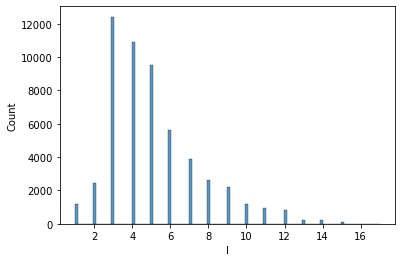

In [295]:
path_df = lenght_all_pairs_shortest_path(cent_nets['16'])
print(path_df['l'].max())
sns.histplot(path_df['l'])

In [296]:
len(path_df)

54397

In [298]:
path_df[path_df['l'] == 17].drop_duplicates('p')

,l,p
36426,17,"['IV überkommen', 'N fülle', 'PR ane', 'N tag', 'N sohn', 'N könig', 'PR ze', 'IV nehmen', 'PR mit', 'N dürigen', 'PR von', 'N leute', 'AJ verständig', 'PR aus', 'N übung', 'N tat', 'AJ retterlich']"


17


<AxesSubplot:xlabel='l', ylabel='Count'>

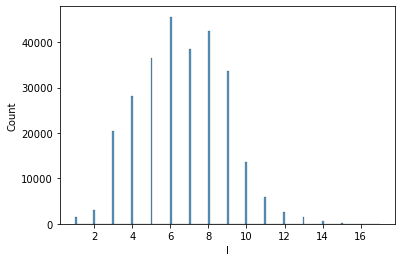

In [299]:
path_df = lenght_all_pairs_shortest_path(cent_nets['17'])
print(path_df['l'].max())
sns.histplot(path_df['l'])

In [300]:
path_df[path_df['l'] == 17].drop_duplicates('p')

,l,p
130272,17,"['IV mahnen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS erlösen', 'AR aus', 'N betrübnisse', 'AJ vielfältig']"
187714,17,"['PCPS sehen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS erlösen', 'AR aus', 'N betrübnisse', 'AJ vielfältig']"


17


<AxesSubplot:xlabel='l', ylabel='Count'>

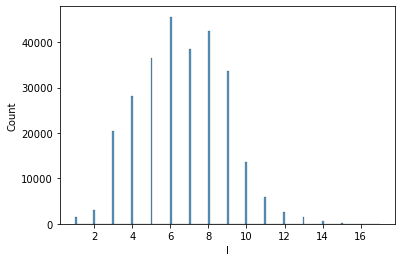

In [313]:
path_df = lenght_all_pairs_shortest_path(cent_nets['17'])
print(path_df['l'].max())
sns.histplot(path_df['l'])

# Analysis of Hirearchy

- using Graph Hierarchy https://github.com/shuaib7860/GraphHierarchy

## Nodal Measures: Hirearchichal Levels
- Hierarchical levels is a generalisation of the notion of trophic levels and describes each vertex’s rank with respect to
“enegry” or “information” flow.
- Influence centrality is a measure of a vertex’s ability to influence the long term state of the graph.
- The democracy coefficient measures the feedback that is present in the graph.
- The hierarchical incoherence parameter is a straightforward generalisation of trophic incoherence.

In [327]:
h_measures_df = []

for cent, G in tqdm(cent_nets.items()):
    
    tmp_df = pd.concat([
            
            pd.Series(
                list(G.nodes), 
                name='node'
            ),
        
            pd.Series(
                gh.hierarchical_levels(G, weight='frequency'), 
                name='hierarchical_levels'
            )
        ], axis=1
    )
    
    tmp_df['cent'] = cent
    
    f_hierarchical_levels, f_influence_centrality, f_hierarchical_diff_adj_sparse, f_democracy_coefficient, f_hierarchical_incoherence = gh.forward_hierarchical_metrics(G, weight='frequency')
    
    b_hierarchical_levels, b_influence_centrality, b_hierarchical_diff_adj_sparse, b_democracy_coefficient, b_hierarchical_incoherence = gh.backward_hierarchical_metrics(G, weight='frequency')
    
    tmp_df['f_hierarchical_levels'] = f_hierarchical_levels
    tmp_df['b_hierarchical_levels'] = b_hierarchical_levels
    
    tmp_df['f_influence_centrality'] = f_influence_centrality
    tmp_df['b_influence_centrality'] = b_influence_centrality
    
    tmp_df['f_democracy_coefficient'] = f_democracy_coefficient
    tmp_df['b_democracy_coefficient'] = b_democracy_coefficient
    
    tmp_df['f_hierarchical_incoherence'] = f_hierarchical_incoherence
    tmp_df['b_hierarchical_incoherence'] = b_hierarchical_incoherence
    
    path_df = lenght_all_pairs_shortest_path(G)
    tmp_df['diameter directed'] = path_df['l'].max()

    if False:
        G_u = G.to_undirected()
        Gcc = sorted(nx.connected_components(G_u), key=len, reverse=True)
        giant = G_u.subgraph(Gcc[0])
        pass
    
    tmp_df['diameter undirected'] = nx.diameter(giant)
    
    tmp_df = pd.merge(
        pd.DataFrame(G.out_degree(), columns=['node', 'out_degree']),
        tmp_df,
        on='node', how='right'
    )
    
    tmp_df = pd.merge(
        pd.DataFrame(G.in_degree(), columns=['node', 'in_degree']),
        tmp_df,
        on='node', how='right'
    )
    
    
    h_measures_df.append(tmp_df)
    
    del path_df
#     break
    pass
    
h_measures_df = pd.concat(h_measures_df).reset_index(drop=True)
len(h_measures_df)

cent_to_num = {
    '11': 11.0, '12': 12.0, '13': 13.0, 'E14': 14.1, 'L14': 14.2, '15': 15.0, '16': 16.0, '17': 17.0
}

h_measures_df['cent_num'] = h_measures_df['cent'].map(cent_to_num)
# cent_to_num

h_measures_df.insert(1, 'node func', h_measures_df['node'].apply(lambda x: x.split(' ')[0]))
h_measures_df.insert(4, 'degree', h_measures_df['in_degree'] + h_measures_df['out_degree'])

h_measures_df

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:39<00:00,  4.95s/it]


,node,node func,in_degree,out_degree,hierarchical_levels,cent,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,diameter directed,cent_num
0,AX werden,AX,0,183,-1.320221,11,-1.674651,0.965791,1.000000e+00,7.303758e-11,7.800235e-08,-1.209715e-07,0.534515,0.763447,7,11.0
1,PP er,PP,22,1,0.489236,11,-0.435741,-1.414213,2.357962e-10,-1.481202e-06,7.800235e-08,-1.209715e-07,0.534515,0.763447,7,11.0
2,AX sin,AX,0,10,-1.695978,11,-2.320245,1.071711,1.000000e+00,2.614507e-08,7.800235e-08,-1.209715e-07,0.534515,0.763447,7,11.0
3,PCPS werden,PCPS,1,14,-1.139316,11,-1.320246,0.958387,7.590899e-07,-1.740203e-09,7.800235e-08,-1.209715e-07,0.534515,0.763447,7,11.0
4,V werden,V,0,73,-0.895396,11,-1.276935,0.513857,1.000000e+00,4.914689e-10,7.800235e-08,-1.209715e-07,0.534515,0.763447,7,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,AJ unein,AJ,1,0,-0.285393,17,-0.578413,-0.007627,-6.337219e-06,1.000000e+00,6.230861e-07,1.096569e-06,0.604803,0.773097,17,17.0
6509,AJ ungedultig,AJ,1,0,-0.285393,17,-0.578413,-0.007627,-6.337219e-06,1.000000e+00,6.230861e-07,1.096569e-06,0.604803,0.773097,17,17.0
6510,AJ unlustig,AJ,1,0,-0.285393,17,-0.578413,-0.007627,-6.337219e-06,1.000000e+00,6.230861e-07,1.096569e-06,0.604803,0.773097,17,17.0
6511,N gleich,N,1,0,-0.285393,17,-0.578413,-0.007627,-6.337219e-06,1.000000e+00,6.230861e-07,1.096569e-06,0.604803,0.773097,17,17.0


In [389]:
'''
CORRELATION TEST
https://realpython.com/numpy-scipy-pandas-correlation-python/
'''

col_1 = ['', 'in_degree', 'out_degree', 'degree'][1]
col_2 = ['',
    'f_hierarchical_levels', 'b_hierarchical_levels', 'hierarchical_levels',
    'f_influence_centrality', 'b_influence_centrality'
][1]

print('Spearmanr Correlation between "{}" and "{}"'.format(col_1, col_2))

for cent_num in h_measures_df['cent_num'].unique():
    df = h_measures_df[h_measures_df['cent_num'] == cent_num]

    print('cent: {} | {}'.format(cent_num, stats.spearmanr(df[col_1], df[col_2])))
# diameter

print('cent: ALL | {}'.format(stats.spearmanr(h_measures_df[col_1], h_measures_df[col_2])))

Spearmanr Correlation between "in_degree" and "f_hierarchical_levels"
cent: 11.0 | SpearmanrResult(correlation=0.25332275367303286, pvalue=1.4732704675850886e-07)
cent: 12.0 | SpearmanrResult(correlation=0.2739164242928881, pvalue=5.385920960693259e-09)
cent: 13.0 | SpearmanrResult(correlation=0.28797037629124833, pvalue=6.848185811198025e-15)
cent: 14.1 | SpearmanrResult(correlation=0.25515648889465486, pvalue=8.04578938607755e-12)
cent: 14.2 | SpearmanrResult(correlation=0.27359272314337607, pvalue=1.69476434684313e-14)
cent: 15.0 | SpearmanrResult(correlation=0.25337479778635524, pvalue=3.241433171909951e-12)
cent: 16.0 | SpearmanrResult(correlation=0.12492036660263267, pvalue=1.4979980383922256e-05)
cent: 17.0 | SpearmanrResult(correlation=0.14756496267704539, pvalue=4.337462859245668e-09)
cent: ALL | SpearmanrResult(correlation=0.18843677636354542, pvalue=3.9968374899895385e-53)


In [16]:
'''
ANOTHER VALIDATION
TODO NOTE: add a column to check number of times function is used
'''

func_frac_df = h_measures_df.groupby(['node func', 'cent']).agg(node_count_func = ('node func', np.size))

func_frac_df['node frac'] = func_frac_df['node_count_func'] / len(h_measures_df)

# dunc_frac_df.to_excel('node_func_possible_more_bugs.xlsx')

func_frac_df.sort_values(by='node frac', ascending=False)

node_count_func  node frac
node func cent                            
N         17    617              0.094734 
          16    546              0.083832 
PCPS      17    337              0.051743 
N         15    298              0.045755 
          13    282              0.043298 
          L14   272              0.041763 
          E14   243              0.037310 
AJ        17    237              0.036389 
PCPS      16    215              0.033011 
          L14   188              0.028865 
          13    175              0.026869 
AJ        16    172              0.026409 
PCPS      E14   170              0.026102 
N         12    161              0.024720 
PCPS      15    161              0.024720 
AD        17    157              0.024106 
AJ        E14   148              0.022724 
N         11    144              0.022110 
AJ        L14   137              0.021035 
PCPS      12    135              0.020728 
          11    130              0.019960 
AJ        15    127              0.019499 
IV        17    126              0.019346 
AJ        13    113              0.017350 
AD        16    110              0.016889 
IV        16    83               0.012744 
AD        L14   72               0.011055 
AJ        11    69               0.010594 
AD        13    62               0.009519 
          15    61               0.009366 
AJ        12    53               0.008138 
AD        E14   51               0.007830 
          12    42               0.006449 
IV        15    37               0.005681 
PR        17    34               0.005220 
AD        11    32               0.004913 
IV        L14   24               0.003685 
PP        16    19               0.002917 
PR        16    19               0.002917 
          L14   18               0.002764 
PCPR      13    18               0.002764 
PR        15    17               0.002610 
          13    16               0.002457 
          E14   16               0.002457 
PCPR      E14   15               0.002303 
PP        17    15               0.002303 
IV        E14   14               0.002150 
PR        11    14               0.002150 
PCPR      L14   13               0.001996 
PP        L14   11               0.001689 
PR        12    11               0.001689 
PP        13    11               0.001689 
          E14   11               0.001689 
          15    10               0.001535 
AR        17    9                0.001382 
DM        13    8                0.001228 
PP        11    8                0.001228 
DM        17    7                0.001075 
PP        12    7                0.001075 
DM        E14   7                0.001075 
AR        16    6                0.000921 
CJ        17    6                0.000921 
MV        17    6                0.000921 
RP        17    6                0.000921 
DM        12    6                0.000921 
V         L14   5                0.000768 
MV        E14   5                0.000768 
          16    5                0.000768 
          15    5                0.000768 
          13    5                0.000768 
V         E14   5                0.000768 
IV        12    5                0.000768 
V         12    4                0.000614 
CJ        E14   4                0.000614 
DM        11    4                0.000614 
          16    4                0.000614 
V         16    4                0.000614 
MV        L14   4                0.000614 
          11    4                0.000614 
          12    4                0.000614 
CJ        15    4                0.000614 
V         11    3                0.000461 
RP        16    3                0.000461 
V         17    3                0.000461 
RP        L14   3                0.000461 
PK        L14   3                0.000461 
CJ        16    3                0.000461 
AR        15    3                0.000461 
CJ        L14   3                0.000461 
AR        12    3                0.000461 
CJ        11    3                0.000461 
AX        E14   3

In [17]:
h_measures_df

# f_democracy_coefficient

h_measures_df[h_measures_df['f_influence_centrality'] > 0.1][['node', 'cent', 'f_influence_centrality', 'f_hierarchical_levels']]

,node,cent,f_influence_centrality,f_hierarchical_levels
0,AX werden,11,1.0,-1.674651
2,AX sin,11,1.0,-2.320245
4,V werden,11,1.0,-1.276935
7,MV mügen,11,1.0,-2.963839
10,MV wellen,11,1.0,-2.466953
12,MV sollen,11,1.0,-1.326236
233,MV müssen,11,1.0,-0.312261
260,N eve,11,1.0,-0.137230
266,N geng,11,1.0,-0.078169
361,PCPS scheinen,11,1.0,-1.055808


In [18]:
if False:
    h_measures_df.to_excel(path_dataset_dir + 'hierarchical_metrics_german.xlsx')
    
if False:
    h_measures_df = pd.read_excel(path_dataset_dir + 'hierarchical_metrics_german.xlsx')

In [19]:
print(h_measures_df['cent'].value_counts())
h_measures_df.columns

17     1568
16     1194
L14    759 
15     734 
13     703 
E14    697 
12     439 
11     419 
Name: cent, dtype: int64


Index(['node', 'hierarchical_levels', 'node func', 'cent',
       'f_hierarchical_levels', 'b_hierarchical_levels',
       'f_influence_centrality', 'b_influence_centrality',
       'f_democracy_coefficient', 'b_democracy_coefficient',
       'f_hierarchical_incoherence', 'b_hierarchical_incoherence', 'cent_num'],
      dtype='object')

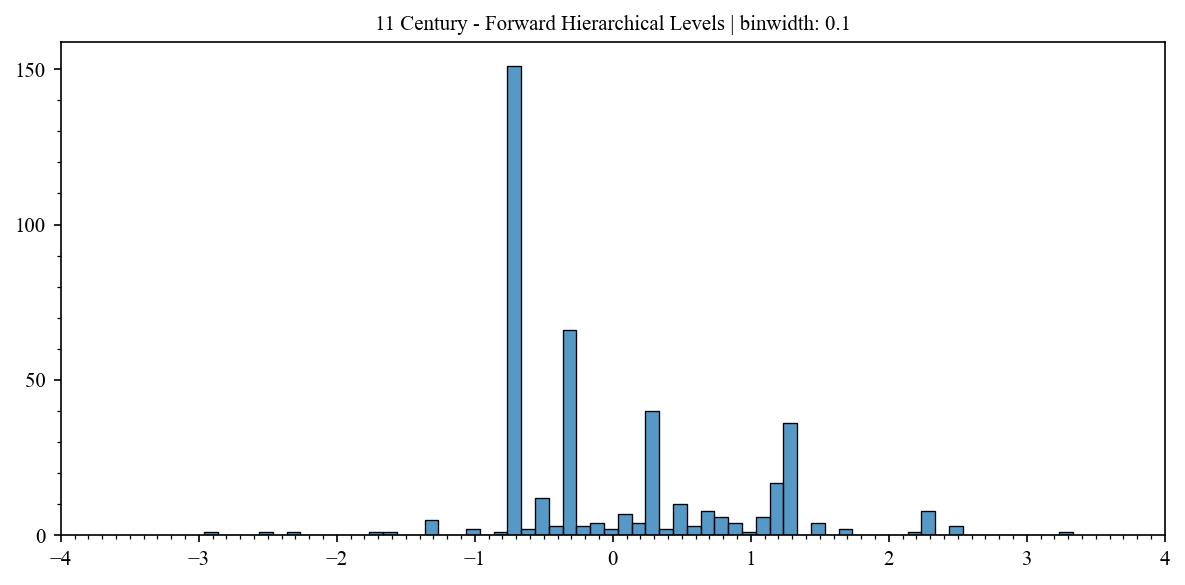

In [20]:
def plot_hirearchy_measure_single_cent(h_measures_df, cent, binwidth, figsize):
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 12

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

    plt.figure(figsize=figsize, dpi=150)

    h_levels_tmp = h_measures_df[h_measures_df['cent'] == cent]

    g = sns.histplot(
        data=h_levels_tmp, x='f_hierarchical_levels', binwidth=binwidth
    )
    
    g.set_title('{} Century - Forward Hierarchical Levels | binwidth: {}'.format(cent, binwidth), loc='center')
    g.set(xlabel='', ylabel='', xlim=(-4, 4))
    
    g.xaxis.set_major_locator(plt.MultipleLocator(1))
    g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
    
    g.yaxis.set_major_locator(plt.MultipleLocator(50))
    g.yaxis.set_minor_locator(plt.MultipleLocator(10))

    plt.tight_layout()

    pass

plot_hirearchy_measure_single_cent(h_measures_df=h_measures_df, binwidth=0.1, cent='11', figsize=(8,4))

8it [00:03,  2.59it/s]


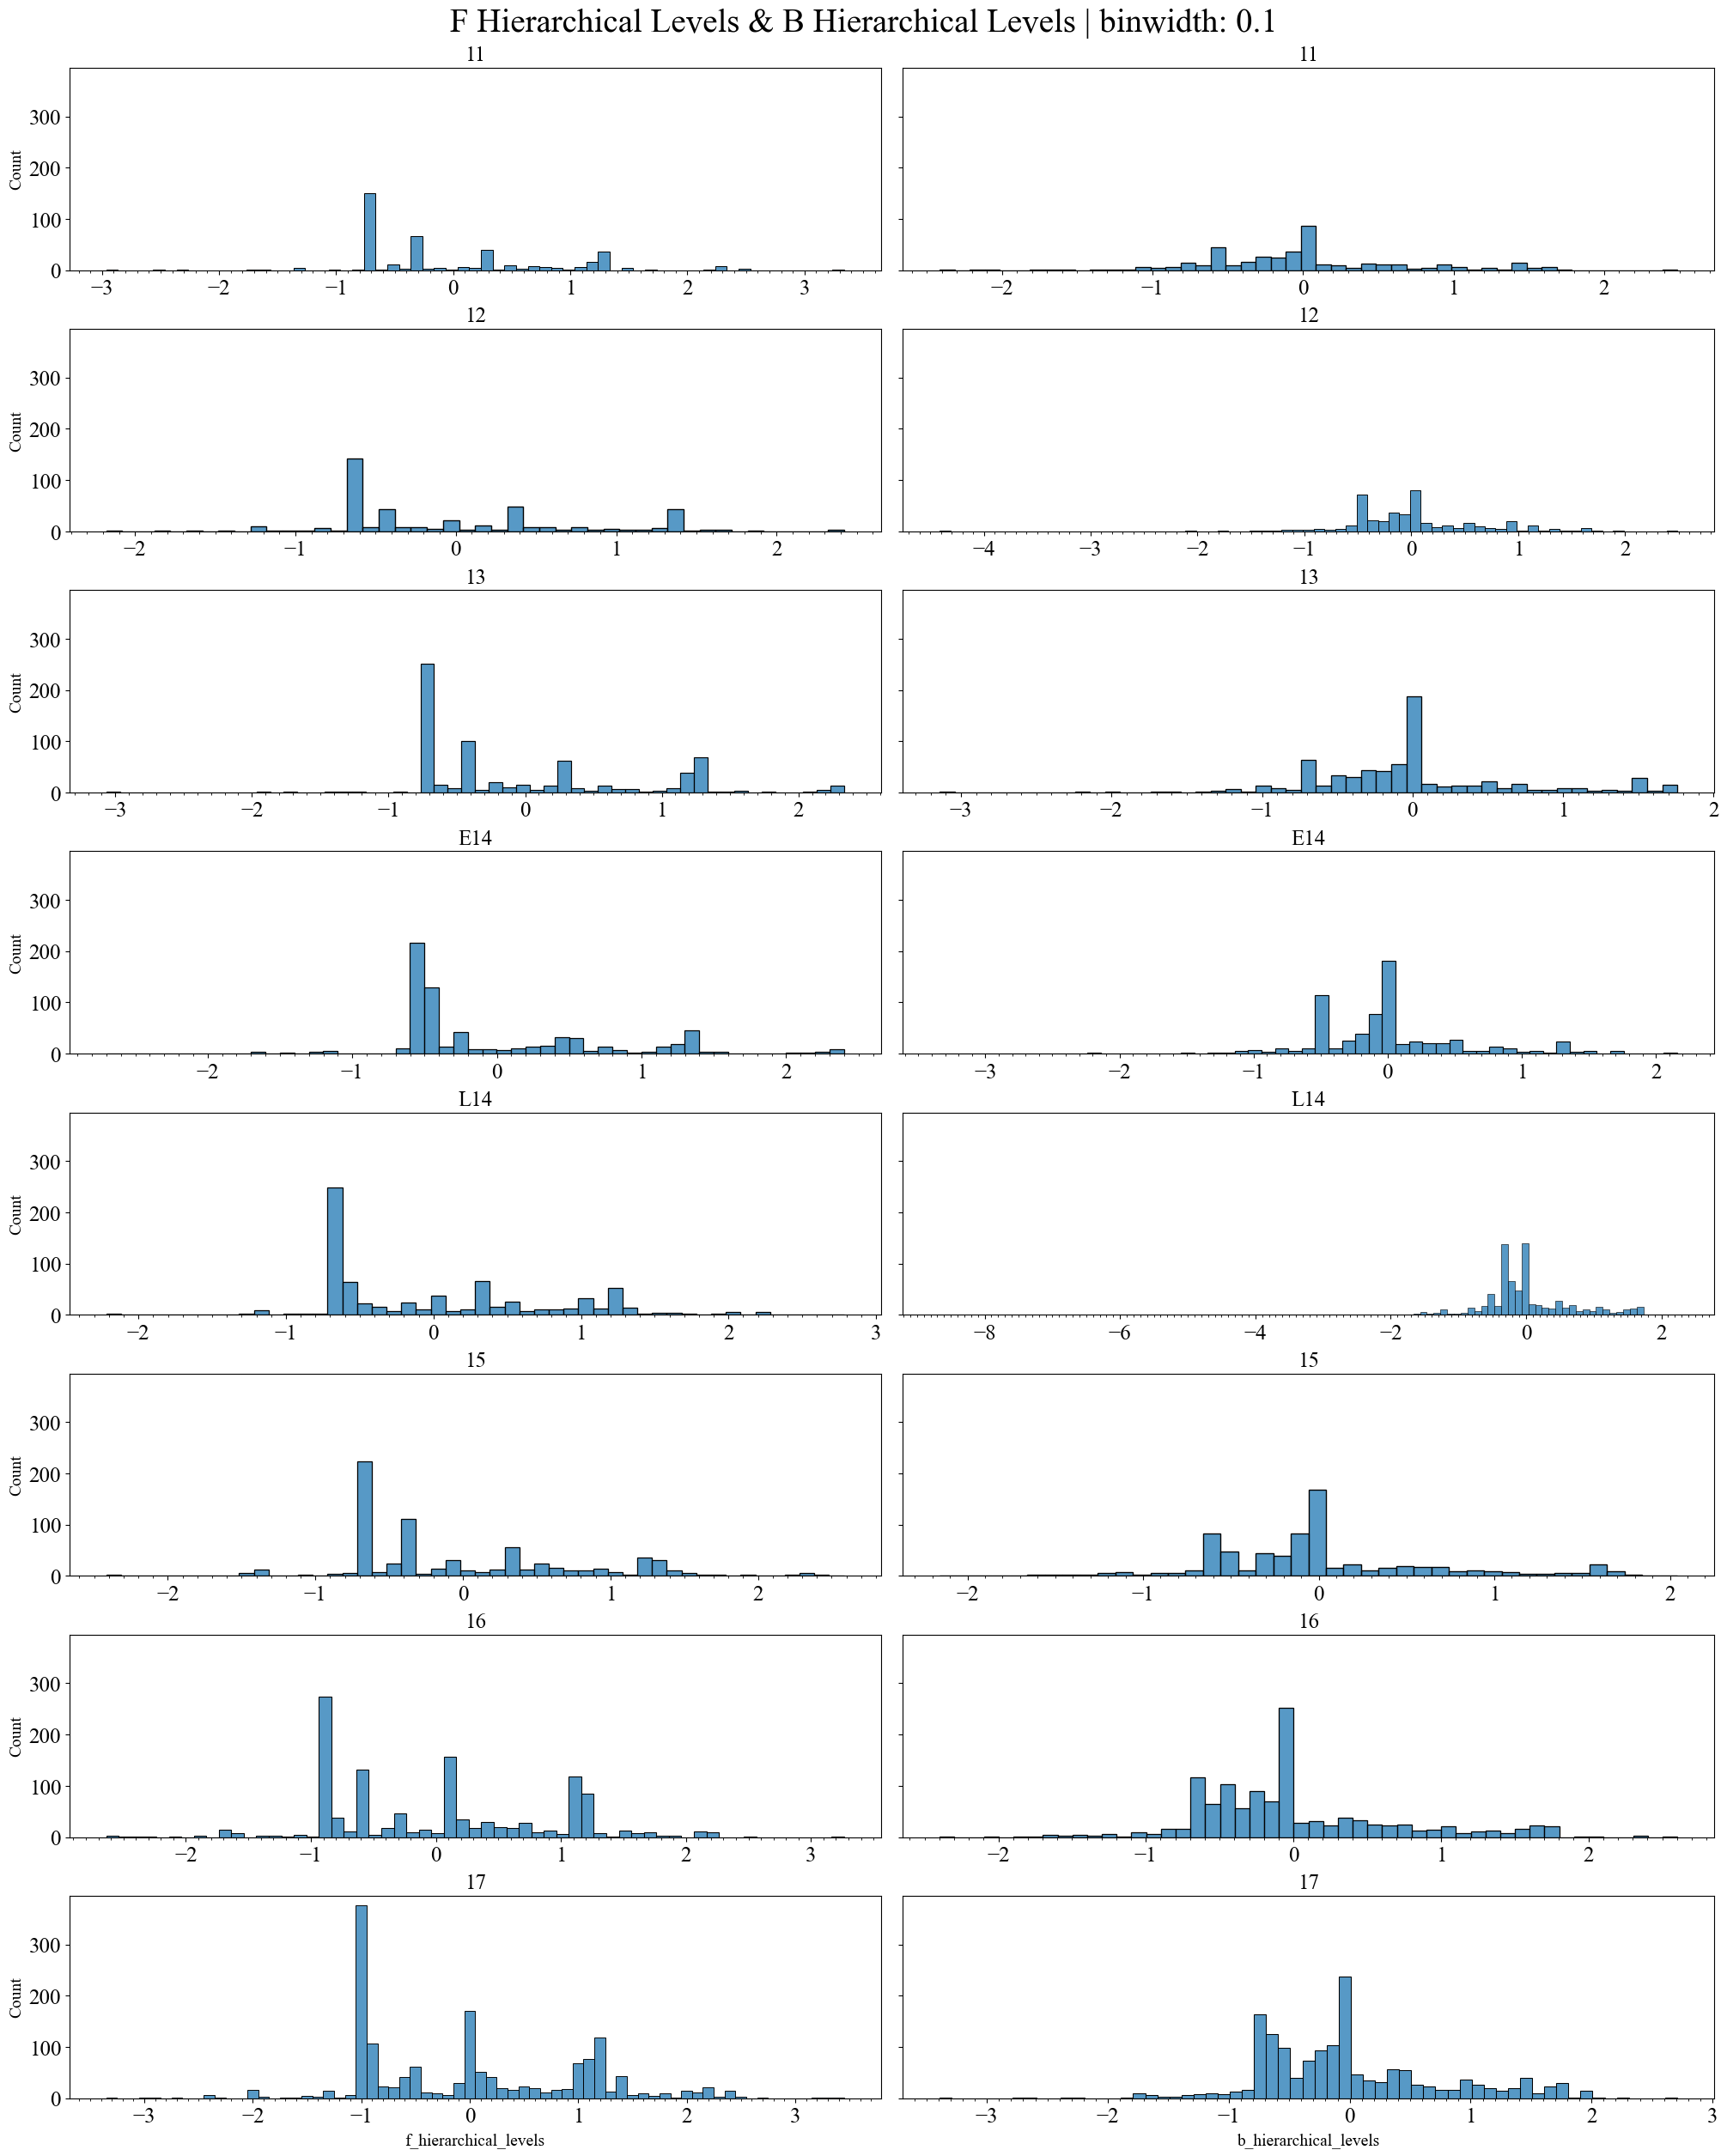

In [71]:
def plot_hirearchy_measure(h_measures_df, binwidth, func_names, ylim_dict=None):
    SMALL_SIZE = 18
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 28

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

    fig, axes = plt.subplots(nrows=len(cent_nets.keys()), ncols=2, constrained_layout=True,
        sharex=False, sharey=True, dpi=100, figsize=(20, 25))

    fig.suptitle('{} | binwidth: {}'.format(
        ' & '.join(func_names).replace('_', ' ').title(), binwidth
    ))
    
    cents = list(cent_nets.keys())
    
    for row, cent in tqdm(enumerate(cents)):

        h_levels_tmp = h_measures_df[h_measures_df['cent'] == cent]

        g = sns.histplot(
            data=h_levels_tmp, x=func_names[0],
            ax=axes[row, 0], binwidth=binwidth
        )
        
        g.set_title('{}'.format(cent), loc='center')
        
        g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
        
        # write xlabel only for last plot in column
        if cent != cents[-1]:
            g.set(xlabel='')
        
        if False:
            g.set(ylim=(0, ylim_dict[binwidth]) #, xlim=(0, 1), 
                  #xlabel=covars_latex_dicts[x_col], ylabel=covars_latex_dicts[y_col]
            )
            pass
#         g.xaxis.set_major_locator(plt.MultipleLocator(1))
#         g.yaxis.set_major_locator(plt.MultipleLocator(100))
#         print(ylim_dict[binwidth])
        '''-------------------------------'''
        g = sns.histplot(
            data=h_levels_tmp, x= func_names[1],
            ax=axes[row, 1], binwidth=binwidth
        )
        g.set_title('{}'.format(cent), loc='center')
        
        g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
        
        # write xlabel only for last plot in column
        if cent != cents[-1]:
            g.set(xlabel='')
        
        if False:
            g.set(ylim=(0, ylim_dict[binwidth]) #, xlim=(0, 1), 
                  #xlabel=covars_latex_dicts[x_col], ylabel=covars_latex_dicts[y_col]
            )
            pass
#         g.xaxis.set_major_locator(plt.MultipleLocator(1))
#         g.yaxis.set_major_locator(plt.MultipleLocator(100))

        pass
    pass

binwidth = [0.1, None][0]
# func_name = ['hierarchical_levels', 'forward_hierarchical_levels'][1]
func_names = [
    ('hierarchical_levels', 'f_hierarchical_levels'),
    ('hierarchical_levels', 'b_hierarchical_levels'),
    ('f_hierarchical_levels', 'b_hierarchical_levels'),
    
#     ('f_influence_centrality', 'f_hierarchical_levels')
][-1]
# ylim_dicts={
#     ('forward_hierarchical_levels weighted', 'backward_hierarchical_levels weighted'): {
#         0.25:300, 0.5: 250, 0.75: 300, 1.0: 350, None: 400},
#     ('hierarchical_levels weighted', 'forward_hierarchical_levels weighted'): {None: 400},
#     ('hierarchical_levels weighted', 'backward_hierarchical_levels weighted'): {None: 400},
# }

plot_hirearchy_measure(h_measures_df=h_measures_df, 
                       binwidth=binwidth, 
#                        ylim_dict=ylim_dicts[func_names], 
                       func_names=func_names)

In [72]:
h_measures_df.describe()

,hierarchical_levels,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,cent_num
count,6.513000e+03,6.513000e+03,6.513000e+03,6.513000e+03,6.513000e+03,6.513000e+03,6.513000e+03,6513.000000,6513.000000,6513.000000
mean,6.218476e-17,1.570983e-16,3.245608e-17,1.489437e-02,4.339017e-01,3.466340e-07,9.267077e-05,0.530799,0.744688,14.799862
std,6.803071e-01,8.853140e-01,6.932463e-01,1.211351e-01,4.956495e-01,3.454182e-07,2.548397e-04,0.046664,0.147223,1.826405
min,-2.537370e+00,-3.351440e+00,-8.665899e+00,-3.563290e-04,-8.112304e-04,-2.371749e-07,-3.319631e-07,0.473071,0.573549,11.000000
25%,-4.293705e-01,-6.729602e-01,-4.545170e-01,-4.179055e-06,-2.400378e-07,8.694418e-08,-4.340678e-08,0.494711,0.673499,14.100000
50%,-9.657866e-02,-2.769349e-01,-5.015025e-02,2.071221e-07,2.550180e-05,3.206034e-07,1.662640e-07,0.519239,0.721331,15.000000
75%,4.832857e-01,6.195043e-01,2.557622e-01,6.522645e-06,1.000000e+00,5.046549e-07,5.268724e-07,0.538600,0.772943,16.000000
max,5.680742e+00,3.393678e+00,2.697443e+00,1.000000e+00,1.000001e+00,8.424879e-07,7.942837e-04,0.604767,1.236668,17.000000


In [ ]:
# cen = '11'
# plt.figure(figsize=(15,8))
# sns.histplot(data=h_measures_df[h_measures_df['cent'] == cent], x='f_influence_centrality')

In [21]:
h_measures_df.columns

Index(['node', 'hierarchical_levels', 'node func', 'cent',
       'f_hierarchical_levels', 'b_hierarchical_levels',
       'f_influence_centrality', 'b_influence_centrality',
       'f_democracy_coefficient', 'b_democracy_coefficient',
       'f_hierarchical_incoherence', 'b_hierarchical_incoherence', 'cent_num'],
      dtype='object')

## FHL

In [35]:
h_measures_df['cent_FHL'] = h_measures_df.apply(lambda r: (r['cent'], round(r['f_hierarchical_levels'], 3)), axis=1)

In [41]:
nodes_FHL_df = (
    h_measures_df
    .groupby('node')
    .agg(
        FHL_avg=('f_hierarchical_levels', np.mean), 
        FHL_std=('f_hierarchical_levels', np.std), 
        count_cent=('cent', np.size),
        cent_FHL=('cent_FHL', lambda x: list(x))
    )
    .sort_values(by='FHL_std', ascending=False)
)

if True:
    nodes_FHL_df.to_excel('nodes_FHL_df.xlsx')
    
nodes_FHL_df[nodes_FHL_df.index == 'N geist']

,FHL_avg,FHL_std,count_cent,cent_FHL
node,,,,
N geist,0.144851,0.7086,8,"[(11, 1.296), (12, 0.194), (13, -0.683), (E14, 0.689), (L14, 0.327), (15, 0.256), (16, -0.922), (17, 0.002)]"


In [66]:
print('Number of nodes exists only single century (std=0):', sum(nodes_FHL_df['FHL_std'].isnull()), 'from', len(nodes_FHL_df))

for r in reversed(np.arange(0.5, 2.1, 0.25)):

    print('Number of Nodes with std >= {}: {} from {} | Exists in {} centuries'.format(
        r,
        sum(nodes_FHL_df['FHL_std'] >= r),
        sum(~nodes_FHL_df['FHL_std'].isnull()),
        round(nodes_FHL_df[nodes_FHL_df['FHL_std'] >= r]['count_cent'].mean(), 2)
    ))

Number of nodes exists only single century (std=0): 3331 from 4405
Number of Nodes with std >= 2.0: 3 from 1074 | Exists in 2.0 centuries
Number of Nodes with std >= 1.75: 10 from 1074 | Exists in 2.0 centuries
Number of Nodes with std >= 1.5: 23 from 1074 | Exists in 2.09 centuries
Number of Nodes with std >= 1.25: 65 from 1074 | Exists in 2.18 centuries
Number of Nodes with std >= 1.0: 131 from 1074 | Exists in 2.47 centuries
Number of Nodes with std >= 0.75: 206 from 1074 | Exists in 2.8 centuries
Number of Nodes with std >= 0.5: 341 from 1074 | Exists in 2.95 centuries


## Influence Centrality

In [76]:
'''Forward'''
heads_f_influence_centrality = h_measures_df[h_measures_df['f_influence_centrality'] > 0.1].groupby(['node', 'cent']).agg(count = ('cent', np.size))

head_f_influence = (
    heads_f_influence_centrality
    .reset_index()
    .pivot(index=['node'], columns='cent', values='count')
    .fillna(0)
)

head_f_influence['sum'] = head_f_influence.sum(axis=1)

head_f_influence = head_f_influence.sort_values(by=['sum'], ascending=False)

if True:
    head_f_influence.to_excel(path_dataset_dir + 'influence_cent_forward_high_0.1.xlsx')

head_f_influence

cent,11,12,13,15,16,17,E14,L14,sum
node,,,,,,,,,
MV sollen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AX sin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AX werden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
V werden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV wellen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV müssen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV mögen,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
MV können,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0
V kommen,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0


In [77]:
'''Backward'''
heads_f_influence_centrality = h_measures_df[h_measures_df['b_influence_centrality'] > 0.1].groupby(['node', 'cent']).agg(count = ('cent', np.size))

head_f_influence = (
    heads_f_influence_centrality
    .reset_index()
    .pivot(index=['node'], columns='cent', values='count')
    .fillna(0)
)

head_f_influence['sum'] = head_f_influence.sum(axis=1)

head_f_influence = head_f_influence.sort_values(by=['sum'], ascending=False)

if True:
    head_f_influence.to_excel(path_dataset_dir + 'influence_cent_backward_high_0.1.xlsx')

head_f_influence

cent,11,12,13,15,16,17,E14,L14,sum
node,,,,,,,,,
AD so,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AJ all,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AJ unser,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AJ dise,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AD ouch,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...
AJ sätzig,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
AJ swære,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
AJ switz,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [78]:
[n for n in nodes_all_cent if 'werden' in n]

['PCPS werden', 'AX werden', 'IV werden', 'V werden']

In [79]:
h_measures_df

,node,hierarchical_levels,node func,cent,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,cent_num
0,AX werden,-1.320221,AX,11,-1.674651,0.965791,1.000000e+00,7.303758e-11,7.800235e-08,-1.209715e-07,0.534515,0.763447,11.0
1,PP er,0.489236,PP,11,-0.435741,-1.414213,2.357962e-10,-1.481202e-06,7.800235e-08,-1.209715e-07,0.534515,0.763447,11.0
2,AX sin,-1.695978,AX,11,-2.320245,1.071711,1.000000e+00,2.614507e-08,7.800235e-08,-1.209715e-07,0.534515,0.763447,11.0
3,PCPS werden,-1.139316,PCPS,11,-1.320246,0.958387,7.590899e-07,-1.740203e-09,7.800235e-08,-1.209715e-07,0.534515,0.763447,11.0
4,V werden,-0.895396,V,11,-1.276935,0.513857,1.000000e+00,4.914689e-10,7.800235e-08,-1.209715e-07,0.534515,0.763447,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,AJ unein,-0.285399,AJ,17,-0.578425,-0.007627,-1.945246e-06,1.000000e+00,8.424879e-07,5.268724e-07,0.604767,0.772943,17.0
6509,AJ ungedultig,-0.285399,AJ,17,-0.578425,-0.007627,-1.945246e-06,1.000000e+00,8.424879e-07,5.268724e-07,0.604767,0.772943,17.0
6510,AJ unlustig,-0.285399,AJ,17,-0.578425,-0.007627,-1.945246e-06,1.000000e+00,8.424879e-07,5.268724e-07,0.604767,0.772943,17.0
6511,N gleich,-0.285399,N,17,-0.578425,-0.007627,-1.945246e-06,1.000000e+00,8.424879e-07,5.268724e-07,0.604767,0.772943,17.0


[None, None]

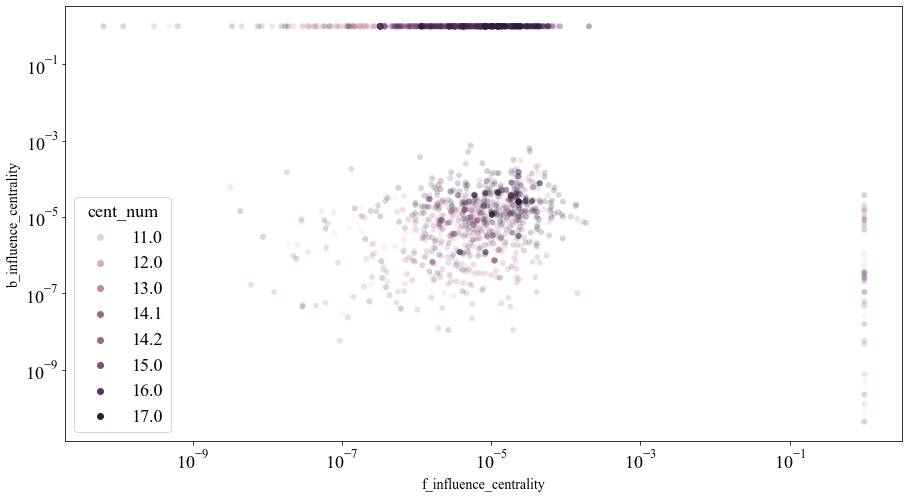

In [80]:
plt.figure(figsize=(15,8))

ax = sns.scatterplot(data=h_measures_df, x='f_influence_centrality', y='b_influence_centrality', 
                     hue='cent_num', alpha=0.2, linewidth=0, legend='full')

ax.set(xscale='log', yscale='log')

# h_measures_df['f_influence_centrality']

Text(0.5, 1.0, 'f_influence_centrality')

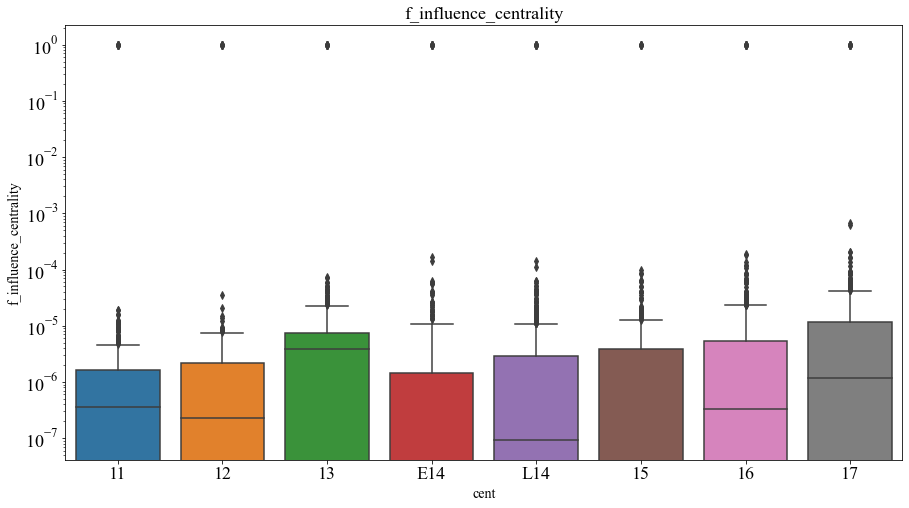

In [81]:
measure = ['f_influence_centrality'][0]

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=h_measures_df, y=measure, x='cent')
ax.set(yscale="log")
ax.set_title(measure)

In [236]:
h_measures_df

,node,hierarchical_levels,cent,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence
0,AX werden,-1.322059,11,-1.678203,0.965916,1.000000e+00,9.098386e-10,1.098341e-07,-1.298933e-07,0.533920,0.763671
1,PP er,0.488087,11,-0.438014,-1.414188,-8.978796e-09,-2.192297e-05,1.098341e-07,-1.298933e-07,0.533920,0.763671
2,AX sin,-1.695372,11,-2.319056,1.071687,1.000000e+00,-1.146232e-08,1.098341e-07,-1.298933e-07,0.533920,0.763671
3,PCPS werden,-1.138701,11,-1.319056,0.958345,-5.256178e-07,-8.508693e-09,1.098341e-07,-1.298933e-07,0.533920,0.763671
4,V werden,-0.895725,11,-1.276866,0.514583,1.000000e+00,-4.383868e-07,1.098341e-07,-1.298933e-07,0.533920,0.763671
...,...,...,...,...,...,...,...,...,...,...,...
6515,AJ unein,-0.285393,17,-0.578413,-0.007627,-1.425639e-07,1.000000e+00,7.258097e-07,7.384140e-07,0.604803,0.773098
6516,AJ ungedultig,-0.285393,17,-0.578413,-0.007627,-1.425639e-07,1.000000e+00,7.258097e-07,7.384140e-07,0.604803,0.773098
6517,AJ unlustig,-0.285393,17,-0.578413,-0.007627,-1.425639e-07,1.000000e+00,7.258097e-07,7.384140e-07,0.604803,0.773098
6518,N gleich,-0.285393,17,-0.578413,-0.007627,-1.425639e-07,1.000000e+00,7.258097e-07,7.384140e-07,0.604803,0.773098


<AxesSubplot:xlabel='f_hierarchical_levels', ylabel='Count'>

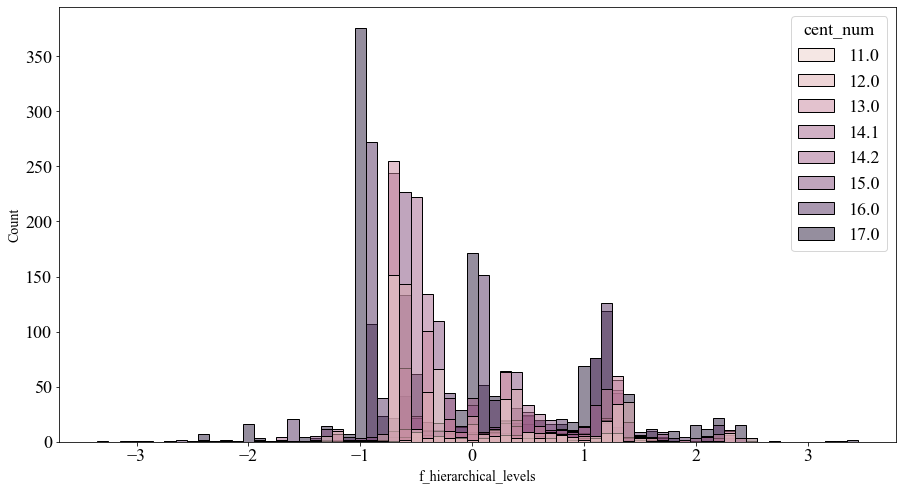

In [83]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='f_hierarchical_levels', hue='cent_num', binwidth=0.1)

<AxesSubplot:xlabel='b_hierarchical_levels', ylabel='Count'>

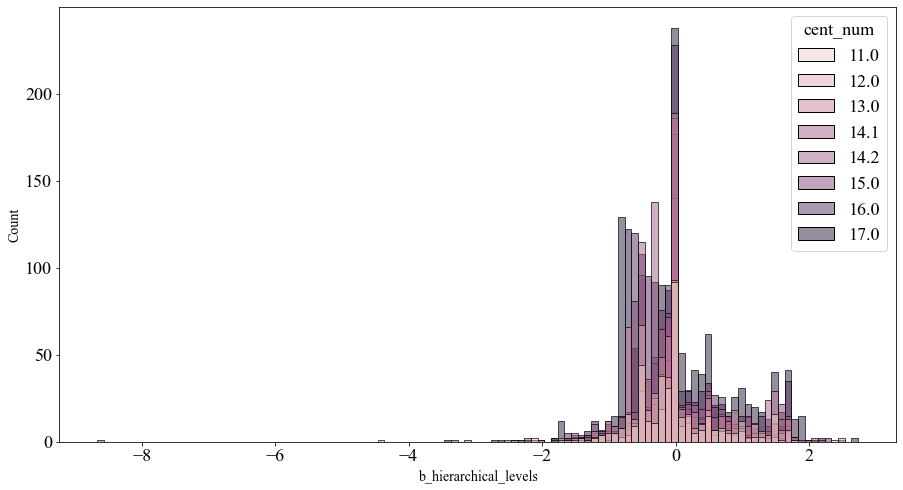

In [85]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='b_hierarchical_levels', hue='cent_num', binwidth=0.1)

<AxesSubplot:xlabel='hierarchical_levels', ylabel='Count'>

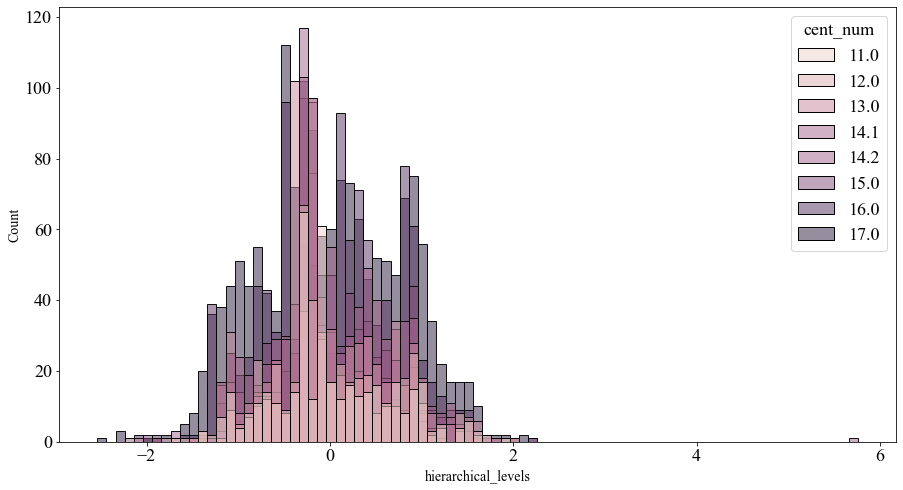

In [84]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='hierarchical_levels', hue='cent_num', binwidth=0.1)

<AxesSubplot:xlabel='hierarchical_levels NOT weighted', ylabel='Count'>

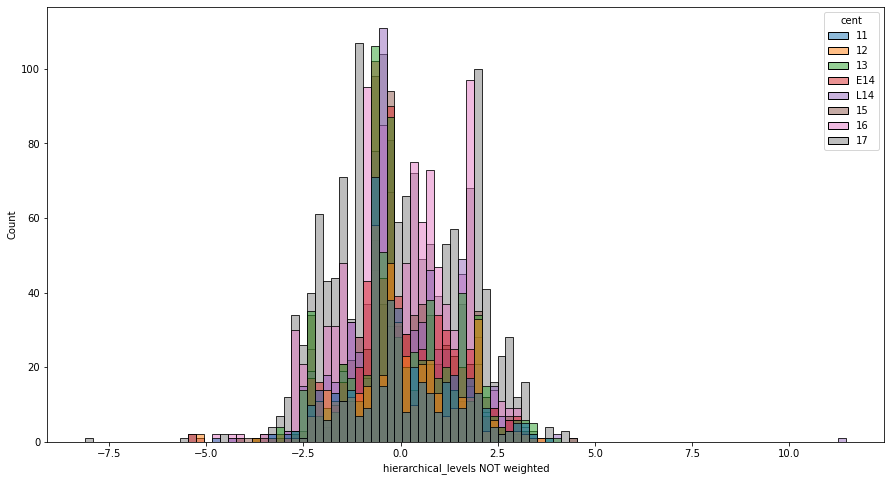

In [75]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_levels_df, x='hierarchical_levels NOT weighted', hue='cent')

In [76]:
# plt.figure(figsize=(15,8))
# sns.histplot(
#     data=h_levels_df[h_levels_df['cent'].isin(['11', '17'])], 
#     x='hierarchical_levels', hue='cent')

In [77]:
# sns.histplot(data=h_levels_df, x='hierarchical_levels', hue='cent')

fig = px.histogram(h_levels_df, x="hierarchical_levels weighted", color="cent", barmode="overlay")

fig.update_xaxes(range=[-9, +12], autorange=False)
fig.update_yaxes(range=[0, 110], autorange=False)

# fig.show()

pio.show(fig, renderer='browser', validate=True)
# fig.write_html(file_save)

## Global Measures: Democracy Coeff and Hierarchical Incoherence

In [86]:
# %config Completer.use_jedi = False
# G.nodes
h_measures_df[h_measures_df['node'] == 'IV werden']

,node,hierarchical_levels,node func,cent,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,cent_num
8,IV werden,-1.338073,IV,11,-1.278327,1.397820,-5.435655e-08,3.194288e-09,7.800235e-08,-1.209715e-07,0.534515,0.763447,11.0
422,IV werden,-1.235796,IV,12,-1.009979,1.461614,-2.774831e-08,-2.984793e-08,-3.679342e-09,-4.340678e-08,0.519239,1.236668,12.0
868,IV werden,-1.188825,IV,13,-1.197343,1.180308,2.502850e-07,-1.340066e-07,5.046549e-07,1.275712e-07,0.485214,0.773452,13.0
1566,IV werden,-1.141002,IV,E14,-1.206318,1.075686,-1.772101e-08,-2.523811e-08,-2.371749e-07,1.662640e-07,0.494711,0.721331,14.1
2261,IV werden,-1.196410,IV,L14,-1.015548,1.377272,-3.840834e-07,-5.041312e-09,8.694418e-08,7.942837e-04,0.501542,0.663706,14.2
3024,IV werden,-1.124658,IV,15,-1.023085,1.226231,9.240812e-07,1.094151e-06,3.641501e-07,1.877722e-07,0.473071,0.573549,15.0
3759,IV werden,-1.284211,IV,16,-1.249192,1.319230,-6.010010e-08,-3.911375e-08,3.206034e-07,-3.319631e-07,0.538600,0.673499,16.0
4950,IV werden,-1.578901,IV,17,-1.460460,1.697343,-9.391003e-08,-6.197824e-07,8.424879e-07,5.268724e-07,0.604767,0.772943,17.0


In [87]:
G.edges[('AX werden', 'IV erben')]
gh.node_backward_influence_centrality(G, 'IV werden', weight='frequency')

-6.197823771980637e-07

In [96]:
dem_forw_df = []

for cent, G in tqdm(cent_nets.items()):
    FHD_adj, FHD_mean, FHD_std = gh.forward_hierarchical_incoherence(G, weight='frequency')
    
#     b_hierarchical_level_vector, b_influence_centrality_vector, b_hierarchical_diff_adj_sparse, b_democracy_coefficient, b_hierarchical_incoherence = gh.backward_hierarchical_metrics(G, weight='frequency')
    
    hierarchical_level_vector, influence_centrality_vector, hierarchical_diff_adj_sparse, democracy_coefficient, hierarchical_incoherence = gh.forward_hierarchical_metrics(G, weight='frequency')
    
    dem_forw_df.append(
        {
            'cent': cent,
            'forward_hierarchical_incoherence avg': FHD_mean,
            'forward_hierarchical_incoherence std': FHD_std,
            'forward_democracy_coefficient': gh.forward_democracy_coefficient(
                G, weight='frequency'),
            'backward_democracy_coefficient': gh.backward_democracy_coefficient(
                G, weight='frequency'),
            'democracy_coefficient': democracy_coefficient,
            'hierarchical_incoherence': hierarchical_incoherence
        }
    )
    
dem_forw_df = pd.DataFrame(dem_forw_df)
dem_forw_df['cent_num'] = dem_forw_df['cent'].map(cent_to_num)
dem_forw_df

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:30<00:00,  3.82s/it]


,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,backward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.000000,0.534515,7.800235e-08,-1.209715e-07,7.800235e-08,0.534515,11.0
1,12,1.000000,0.519239,-3.679342e-09,-4.340678e-08,-3.679342e-09,0.519239,12.0
2,13,0.999999,0.485214,5.046549e-07,1.275712e-07,5.046549e-07,0.485214,13.0
3,E14,1.000000,0.494711,-2.371749e-07,1.662640e-07,-2.371749e-07,0.494711,14.1
4,L14,1.000000,0.501542,8.694418e-08,7.942837e-04,8.694418e-08,0.501542,14.2
5,15,1.000000,0.473071,3.641501e-07,1.877722e-07,3.641501e-07,0.473071,15.0
6,16,1.000000,0.538600,3.206034e-07,-3.319631e-07,3.206034e-07,0.538600,16.0
7,17,0.999999,0.604767,8.424879e-07,5.268724e-07,8.424879e-07,0.604767,17.0


<AxesSubplot:xlabel='hierarchical_incoherence', ylabel='democracy_coefficient'>

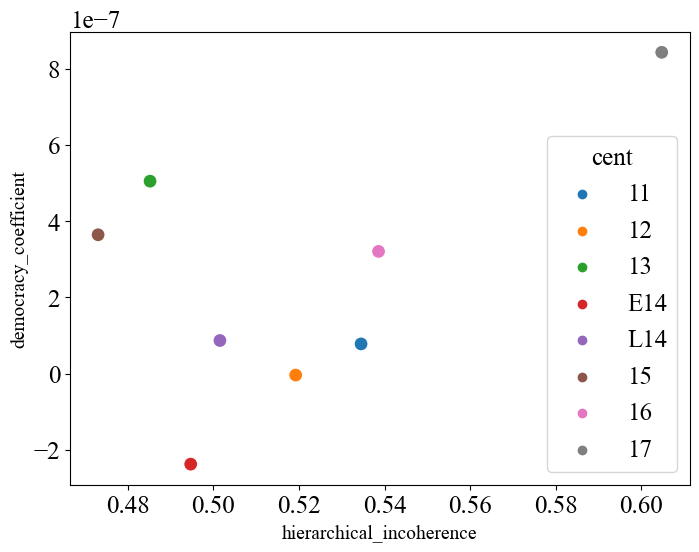

In [89]:
plt.figure(figsize=(8, 6), dpi=100)
sns.scatterplot(data=dem_forw_df, x="hierarchical_incoherence", y="democracy_coefficient", hue='cent',
               s=100, legend='full')

In [90]:
dem_forw_df

,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.000000,0.534515,7.800235e-08,7.800235e-08,0.534515,11.0
1,12,1.000000,0.519239,-3.679342e-09,-3.679342e-09,0.519239,12.0
2,13,0.999999,0.485214,5.046549e-07,5.046549e-07,0.485214,13.0
3,E14,1.000000,0.494711,-2.371749e-07,-2.371749e-07,0.494711,14.1
4,L14,1.000000,0.501542,8.694418e-08,8.694418e-08,0.501542,14.2
5,15,1.000000,0.473071,3.641501e-07,3.641501e-07,0.473071,15.0
6,16,1.000000,0.538600,3.206034e-07,3.206034e-07,0.538600,16.0
7,17,0.999999,0.604767,8.424879e-07,8.424879e-07,0.604767,17.0


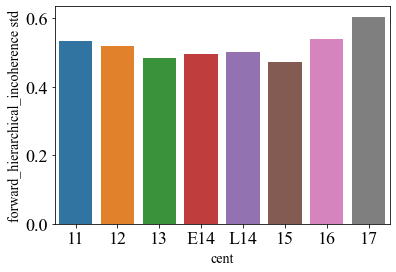

In [91]:
ax = sns.barplot(x="cent", y="forward_hierarchical_incoherence std", data=dem_forw_df)

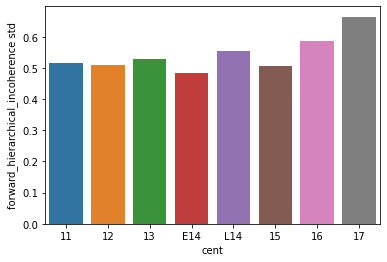

In [32]:
'UNWEIGHTED'

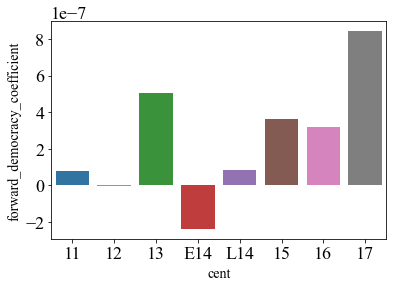

In [92]:
ax = sns.barplot(x="cent", y="forward_democracy_coefficient", data=dem_forw_df)

In [98]:
dem_forw_df

,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,backward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.000000,0.534515,7.800235e-08,-1.209715e-07,7.800235e-08,0.534515,11.0
1,12,1.000000,0.519239,-3.679342e-09,-4.340678e-08,-3.679342e-09,0.519239,12.0
2,13,0.999999,0.485214,5.046549e-07,1.275712e-07,5.046549e-07,0.485214,13.0
3,E14,1.000000,0.494711,-2.371749e-07,1.662640e-07,-2.371749e-07,0.494711,14.1
4,L14,1.000000,0.501542,8.694418e-08,7.942837e-04,8.694418e-08,0.501542,14.2
5,15,1.000000,0.473071,3.641501e-07,1.877722e-07,3.641501e-07,0.473071,15.0
6,16,1.000000,0.538600,3.206034e-07,-3.319631e-07,3.206034e-07,0.538600,16.0
7,17,0.999999,0.604767,8.424879e-07,5.268724e-07,8.424879e-07,0.604767,17.0


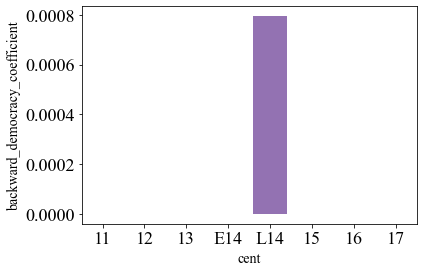

In [97]:
ax = sns.barplot(x="cent", y="backward_democracy_coefficient", data=dem_forw_df)

## Challenges

- https://stackoverflow.com/questions/57458789/get-bin-width-used-for-seaborn-plot
- ITS SO GOOD: https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
- https://stackoverflow.com/questions/56605113/how-to-set-x-axis-ticklabels-in-a-seaborn-plot

# [OLD] yFiles Hierarchical Layout

In [69]:
path_yfiles_layout = 'D:/GoogleDrive/Research/Linguistic project/German/data/Hierarchical Layout yfiles/'

path_networks = OrderedDict()

path_networks['11'] = path_yfiles_layout + "/Cent11.cyjs" 
path_networks['12'] = path_yfiles_layout + "/Cent12.cyjs" 
path_networks['13'] = path_yfiles_layout + "/Cent13.cyjs" 
path_networks['14E'] = path_yfiles_layout + "/Cent14E.cyjs" 

path_networks['14L'] = path_yfiles_layout + "/Cent14L.cyjs" 
path_networks['15'] = path_yfiles_layout + "/Cent15.cyjs" 
path_networks['16'] = path_yfiles_layout + "/Cent16.cyjs" 
path_networks['17'] = path_yfiles_layout + "/Cent17.cyjs" 

In [119]:
layouts = OrderedDict()
cen_layers = {}

for cent, path_layout in path_networks.items():
    f = open(path_layout, "r", encoding='utf-8')
    layouts[cent] = json.loads(f.read())
    
    cen_layers[cent] = []
    
    for node in layouts[cent]['elements']['nodes']:
        
        cen_layers[cent].append({
            'name': node['data']['name'],
            'x': node['position']['x'],
            'y': node['position']['y'],
            'y_round': round(node['position']['y'])
        })
        pass
    
    cen_layers[cent] = pd.DataFrame(cen_layers[cent])
    """Now convert unique y value to sequential layer number"""
    map_y_val_to_layer_num = {
        y: l + 1 for l, y in enumerate(sorted(set(cen_layers[cent]['y_round'])))
    }
    
    cen_layers[cent]['layer'] = cen_layers[cent]['y_round'].map(map_y_val_to_layer_num)
    
    cen_layers[cent] = cen_layers[cent].sort_values('layer').reset_index(drop=True)
#     break
    pass
# del layers
map_y_val_to_layer_num
cen_layers['17'].columns
# cen_layers.keys()

Index(['name', 'x', 'y', 'y_round', 'layer'], dtype='object')

In [121]:
cen_layer_count = []
for cen, cen_layer in cen_layers.items():
    cen_layer_count.append({
        'cent': cen,
        'num layers': cen_layer['layer'].max()
    })
    pass

cen_layer_count = pd.DataFrame(cen_layer_count)

cen_layers['cen_layer_count'] = cen_layer_count

cen_layers['cen_layer_count']

,cent,num layers
0,11,8
1,12,8
2,13,13
3,14E,8
4,14L,13
5,15,10
6,16,18
7,17,28


[(0.0, 30.0), Text(0.5, 1.0, 'Number of Layers in Each Century')]

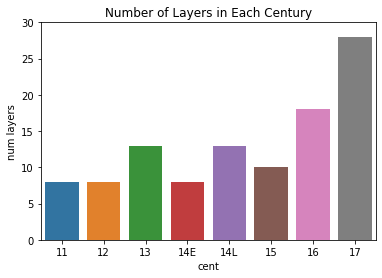

In [136]:
%matplotlib inline

ax=sns.barplot(x="cent", y="num layers", data=cen_layer_count)
ax.set(ylim=(0, 30), title='Number of Layers in Each Century')

In [137]:
save_xls(dfs_dict=cen_layers, 
         xls_path=path_yfiles_layout + '/all_cent_layers_yfiles.xlsx', 
         open=True)

# [OLD] Graph Hierarchy 
- How to draw netwrokx graph https://faculty.math.illinois.edu/~hirani/cbmg/graphs.html
- Add x-y axis when drawing with NetworkX https://stackoverflow.com/questions/56994061/how-to-make-x-and-y-axes-appear-when-using-networkx-and-matplotlib
- A cool toturial for visualization https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial

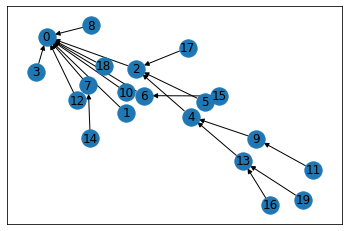

In [22]:

graph = nx.gnr_graph(20, 0.4)
nx.draw_networkx(graph)

In [24]:
l = list(zip(
    graph.nodes(),
#     gh.forward_hierarchical_levels(graph)
    gh.hierarchical_levels(graph)
))

l.sort(key=lambda x: x[1])
l

[(11, -3.0644356955377443),
 (16, -2.759623797025019),
 (19, -2.759623797025019),
 (9, -1.0644356955410164),
 (13, -0.7596237970287615),
 (14, -0.713254593162531),
 (15, -0.713254593162531),
 (5, -0.5697725284144661),
 (17, -0.5697725284144661),
 (1, 0.7234908135033875),
 (3, 0.7234908135033875),
 (8, 0.7234908135033875),
 (10, 0.7234908135033875),
 (12, 0.7234908135033875),
 (18, 0.7234908135033875),
 (4, 1.0879702537436602),
 (6, 1.2867454066645039),
 (7, 1.2867454066645039),
 (2, 1.9828083987402958),
 (0, 2.9885826784782665)]

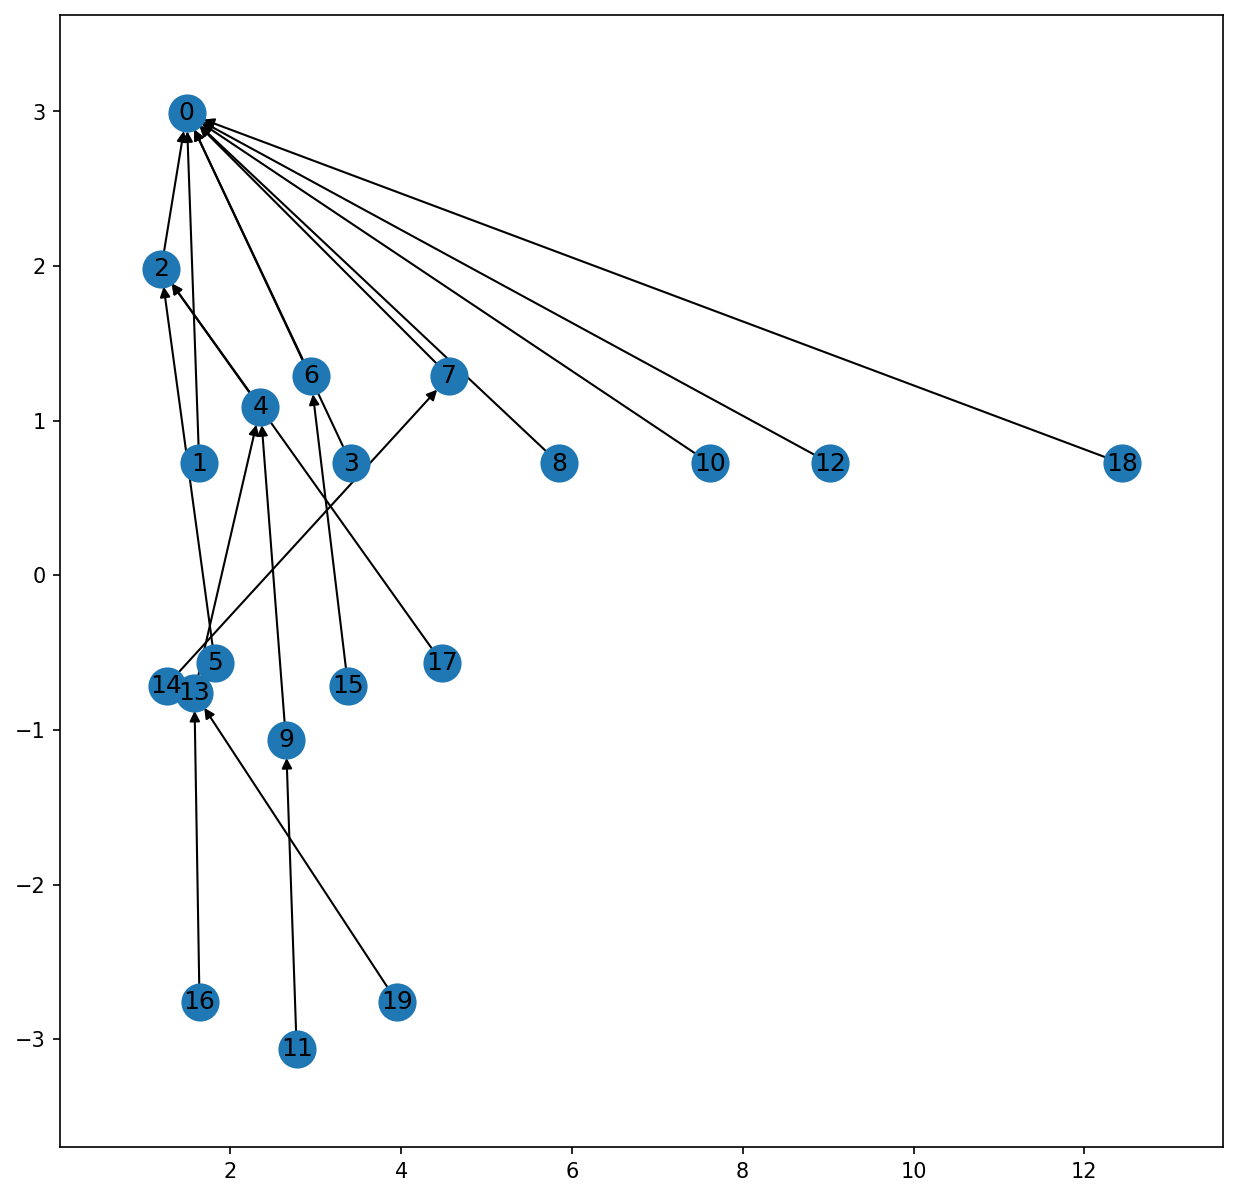

<Figure size 864x864 with 0 Axes>

In [25]:
level_dict = {}
level_num = 0
prev_layer_level = None
offset = 0

for node, level in l:
    if prev_layer_level is not None:
        offset = 1 - (level - prev_layer_level)
    
#     print('l: ', level, 'o: ', offset)
    
    if level not in level_dict:
        level_dict[level] = []
        level_num += 1
        prev_layer_level = level
        pass
    
    level_dict[level].append(node)
#     print(level + (np.sign(level) * 1))
    graph.nodes[node]['pos'] = (
        (len(level_dict[level]) * 2) + random.uniform(-1, 1),
        level 
    )
    pass

# plt.figure(3,figsize=(12,12)) 

fig, ax = plt.subplots()
fig.set_dpi(150)
fig.set_size_inches(10,10)
pos=nx.get_node_attributes(graph,'pos')

plt.figure(3,figsize=(12,12)) 

nx.draw_networkx(graph, pos, ax=ax)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

In [26]:
print('levels: ', len(level_dict))

levels:  11


In [145]:
node_l_dict = dict(l)
node_l_dict[0] - node_l_dict[1]

-0.5258583535426631

In [140]:
gh.forward_hierarchical_differences(graph)


array([[ 0.        , -0.52585835,  1.48484413,  0.        ,  0.        ,
         0.        ,  0.69444045,  0.        ,  0.        ,  0.        ,
         1.48484413,  0.        ,  0.        ,  1.48484413,  0.        ,
         0.        ,  0.89204137,  1.48484413,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.6795719 ,
         0.25233443,  0.        ,  0.        ,  

In [157]:
(hierarchical_differences_sparse, 
 hierarchical_differences_mean, 
 hierarchical_differences_std) = gh.forward_hierarchical_incoherence(graph)

"""The standard deviation of the distribution is known as the forward hierarchical incoherence and is an important metric which gives a measure of a network's organisation and structure."""
print('mean:', hierarchical_differences_mean, 'std:' , hierarchical_differences_std)

mean: 1.0000000000484295 std: 0.4923440574492365


In [158]:
gh.forward_democracy_coefficient(graph)

-4.8429482646383804e-11

In [166]:
for node in graph.nodes:
    print(node, gh.node_forward_influence_centrality(graph, node))

0 -1.421169848470072e-10
1 1.856170772640553e-11
2 1
3 -5.46229728115577e-13
4 4.54081217071689e-14
5 5.0959236830294685e-14
6 1.98507876802978e-11
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1.838296181944088e-11
17 1
18 1
19 1


In [167]:
gh.forward_influence_centrality(graph)


array([[-1.42116985e-10],
       [ 1.85617077e-11],
       [ 1.00000000e+00],
       [-5.46229728e-13],
       [ 4.54081217e-14],
       [ 5.09592368e-14],
       [ 1.98507877e-11],
       [ 1.00000000e+00],
       [ 1.00000000e+00],
       [ 1.00000000e+00],
       [ 1.00000000e+00],
       [ 1.00000000e+00],
       [ 1.00000000e+00],
       [ 1.00000000e+00],
       [ 1.00000000e+00],
       [ 1.00000000e+00],
       [ 1.83829618e-11],
       [ 1.00000000e+00],
       [ 1.00000000e+00],
       [ 1.00000000e+00]])

In [168]:
gh.hierarchical_levels(graph)


array([ 3.44923861,  2.97509697,  0.96439448,  0.97509697, -0.70447493,
       -0.27723747,  1.75479816, -0.24520184, -2.27723747, -0.24520184,
        0.96439448, -2.70447493, -2.27723747,  0.96439448, -2.27723747,
       -1.55894986,  1.55719724,  0.96439448, -1.55894986, -0.44280276])